### **Import Libraries**

In [1]:
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset
import warnings
from functools import partial
from datasets import concatenate_datasets, DatasetDict
from functools import partial 
# Filter out the specific warning
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Key Parameters**

In [2]:
# This cell is tagged with `parameters`
model_name = "bert-base-cased" 
data_link = 'ppower/instruments'
column = 'text'
epochs = 3
seed = 2 
test_size = 0.5

#### **Set Up Path**

In [3]:
results_folder = str(Path(os.getcwd()).parent.parent.absolute())  + '/results/'
figures_folder = str(Path(os.getcwd()).parent.parent.absolute())  + '/figures/'
print(results_folder)

/home/ubuntu/llmft/results/


#### **Helper Functions**

In [4]:
def preprocess_function(examples, column='text'):
    tokenized = tokenizer(examples[column], truncation=True, padding="max_length")
    return {**tokenized, 'label': examples['label']}


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### **Model**

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def add_is_train_column(batch):
    # Length of the batch
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    # Create a list with the same value for all elements in the batch
    batch['is_train'] = [1] * batch_size
    return batch

# Modify the function for the test set
def add_is_test_column(batch):
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    batch['is_train'] = [0] * batch_size
    return batch


In [7]:
def remove_substring(example):
    # The string to be removed
    substring = "True or False: The Right to Counsel is in effect in the tenant's zip code."
    # Replace the substring with an empty string
    example["text"] = example["text"].replace(substring, "")
    return example

#### **Load Data**

In [8]:
original_dataset = load_dataset("ppower1/instrument")
original_dataset = original_dataset.map(remove_substring)
original_dataset = original_dataset['train'].add_column("original_index", range(len(original_dataset['train'])))
dataset = original_dataset.train_test_split(test_size=test_size, seed=seed)
dataset['train'] = dataset['train'].map(add_is_train_column, batched=True)
dataset['test'] = dataset['test'].map(add_is_test_column, batched=True)
tokenized_dataset = dataset.map(partial(preprocess_function, column=column), batched=True)
combined_dataset = concatenate_datasets([dataset['train'], dataset['test']])
combined_dataset = combined_dataset.sort("original_index")
tokenized_original_dataset = combined_dataset.map(partial(preprocess_function, column=column), batched=True)
tokenized_treated_dataset = combined_dataset.map(partial(preprocess_function, column='treated text'), batched=True)
tokenized_control_dataset =  combined_dataset.map(partial(preprocess_function, column='control text'), batched=True)

Map:   0%|          | 0/4898 [00:00<?, ? examples/s]

Map:   0%|          | 0/4899 [00:00<?, ? examples/s]

Map:   0%|          | 0/9797 [00:00<?, ? examples/s]

Map:   0%|          | 0/9797 [00:00<?, ? examples/s]

Map:   0%|          | 0/9797 [00:00<?, ? examples/s]

#### **Hyperparameters**

In [9]:
metric = evaluate.load("accuracy")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def get_training_args(num_epochs):
    return TrainingArguments(
    output_dir='./synth_evict',
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_epochs,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    gradient_checkpointing=True,
    gradient_accumulation_steps=4
)

In [10]:
!rm -rf ./synth_evict/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
# To get the initial training loss
trainer = Trainer(
model=model,
args=TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch"),
train_dataset=tokenized_dataset["train"],
eval_dataset=tokenized_dataset["train"],
compute_metrics=compute_metrics)

init_train_eval = trainer.evaluate()
init_train_loss = init_train_eval['eval_loss']
init_train_accuracy = init_train_eval['eval_accuracy']
print(f"Initial Training Loss: {init_train_loss:.4f}    |   Initial Training Accuracy: {init_train_accuracy:.4f}")

/home/ubuntu/llms/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Initial Training Loss: 0.3320    |   Initial Training Accuracy: 0.9361


In [12]:
# Actual Trainer
trainer = Trainer(
model=model,
args=TrainingArguments(output_dir="test_trainer", 
                       evaluation_strategy="epoch", 
                       num_train_epochs=epochs, 
                       load_best_model_at_end=True,
                       logging_strategy="epoch",
                       save_strategy="epoch"),
train_dataset=tokenized_dataset["train"],
eval_dataset=tokenized_dataset["test"],
compute_metrics=compute_metrics,
)


init_eval_eval = trainer.evaluate()
init_eval_loss = init_eval_eval['eval_loss']
init_eval_accuracy = init_eval_eval['eval_accuracy']
print(f"Initial Evaluation Loss: {init_eval_loss:.4f}    |   Initial Evaluation Accuracy: {init_eval_accuracy:.4f}")

/home/ubuntu/llms/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Initial Evaluation Loss: 0.3316    |   Initial Evaluation Accuracy: 0.9367


In [13]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1839, training_loss=0.26525631645829084, metrics={'train_runtime': 487.3734, 'train_samples_per_second': 30.149, 'train_steps_per_second': 3.773, 'total_flos': 3866153847459840.0, 'train_loss': 0.26525631645829084, 'epoch': 3.0})

In [14]:
steps, train_loss = [0] + [i['step'] for i in trainer.state.log_history if 'loss' in i], [init_train_loss] + [i['loss'] for i in trainer.state.log_history if 'loss' in i]
_, eval_loss = [i['step'] for i in trainer.state.log_history if 'eval_loss' in i], [init_eval_loss] + [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]
eval_accuracy = [init_eval_accuracy] + [i['eval_accuracy'] for i in trainer.state.log_history if 'eval_accuracy' in i]
lr = [i['learning_rate'] for i in trainer.state.log_history if 'learning_rate' in i]

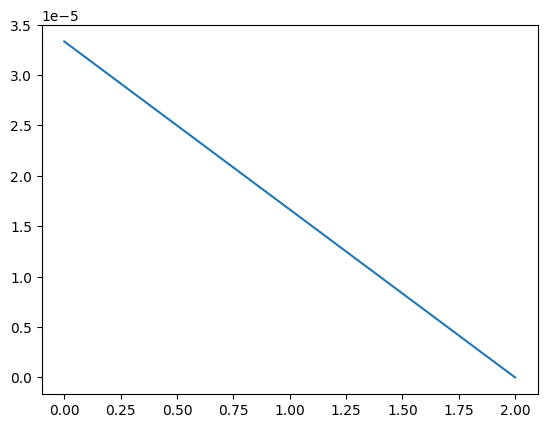

In [15]:
plt.plot(lr)

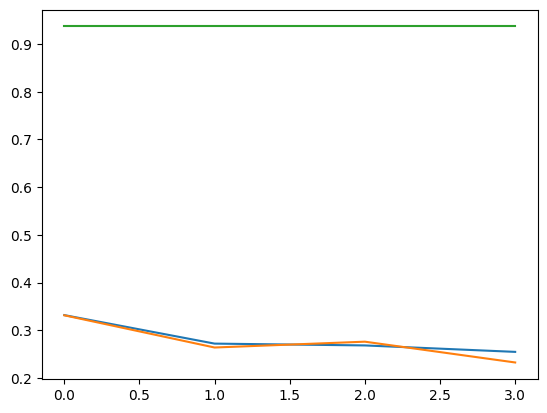

In [16]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.plot(eval_accuracy)
plt.show()

In [17]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_original_dataset).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()

with torch.no_grad():
    treated_predictions = trainer.predict(tokenized_treated_dataset).predictions
    treated_predictions = torch.nn.functional.softmax(torch.tensor(treated_predictions), dim=1)[:,1].numpy()

with torch.no_grad():
    control_predictions = trainer.predict(tokenized_control_dataset).predictions
    control_predictions = torch.nn.functional.softmax(torch.tensor(control_predictions), dim=1)[:,1].numpy()

In [18]:
results = np.hstack((np.array(tokenized_original_dataset['is_train']).reshape(-1,1), original_predictions.reshape(-1,1), treated_predictions.reshape(-1,1), control_predictions.reshape(-1,1) ))

#### **Save Results**

In [19]:
np.save(results_folder + f'legal_aid_{seed}.npy', results)

#### **Clean Up**

In [20]:
!rm -rf ./test_trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
